<a href="https://colab.research.google.com/github/mokoron/EDA/blob/master/pallets_reduced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://miro.medium.com/max/2520/1*3rMzzcOz933RVvaO17UVLg.jpeg">

# Imports

Required imports for notebook setup and loading data from cloud.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
%%capture
!wget  -O "Roboto.zip" "https://fonts.google.com/download?family=Roboto"
!echo A | unzip -q "Roboto.zip"
!mv Roboto-Light.ttf  /usr/share/fonts/truetype/

path = '/usr/share/fonts/truetype/Roboto-Light.ttf'
fontprop = fm.FontProperties(fname=path, size= 12)
fontprop_title = fm.FontProperties(fname=path, size= 32)
fontprop_axis = fm.FontProperties(fname=path, size= 20)

In [ ]:
%%capture
!pip install albumentations --upgrade

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim

from IPython.display import clear_output

np.random.seed(1961)

from utils import *

In [ ]:
!mkdir checkpoints
!unzip -q /drive/My\ Drive/CV_BEER_GARAGE/pallets/data/Line511_train_test.zip

# Params
Parameters for model training.

In [ ]:
params = {
    'batch_size': 4,
    'lr': 2e-3,
    'epochs': 400,
    'device': 'cuda',
    'save_cp': True,
    'dir_checkpoint': './checkpoints',
    'train_path': './Line 511/train/',
    'test_path': './Line 511/test/'
}

# Data loaders

Loading images with special object into required format.

In [ ]:
train_dataset, test_dataset = gen_train_test_loader(params)


Total 141 images loaded



Total 14 images loaded


In [ ]:
train_loader = DataLoader(train_dataset, 
                          batch_size=params['batch_size'], 
                          shuffle=True, 
                          num_workers=1, 
                          pin_memory=True)
test_loader = DataLoader(test_dataset, 
                         batch_size=1, 
                         shuffle=False, 
                         num_workers=1, 
                         pin_memory=True)

# Training

Defining model and optimizers.

In [ ]:
net = NestedUNet(num_classes=1, input_channels=3).to(device=params['device'])
device = params['device']
parameters_opt = list(filter(lambda p: p.requires_grad, net.parameters()))
optimizer = optim.Adam(parameters_opt, lr=params['lr'], weight_decay=6e-6)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=params['epochs'], eta_min=3e-5)
criterion = BCEDiceLoss()

Training procedure.

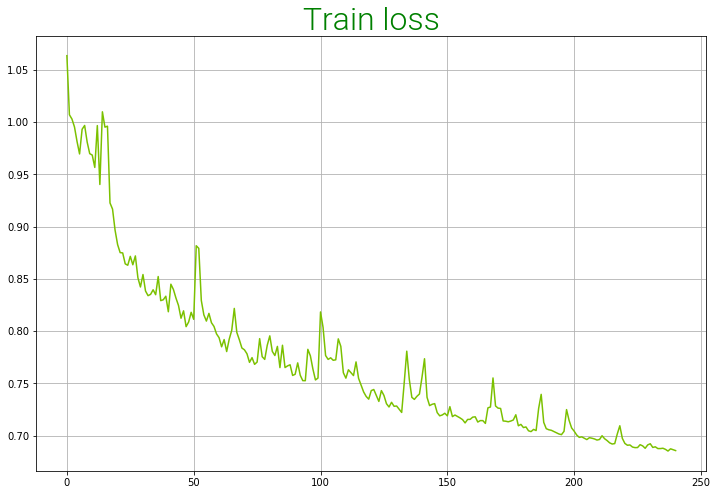

In [ ]:
train(params['epochs'], train_loader, net, optimizer, criterion, device)

Saving trained model to the file for further usage.

In [ ]:
torch.save(net.state_dict(), 'CP_final.pth')

# Model evaluation

Loading pretrained model from file.

In [ ]:
CHKPT_PATH = '/drive/My Drive/CV_BEER_GARAGE/pallets/CP_final.pth'
net.load_state_dict(torch.load(CHKPT_PATH))
net.eval()
print('Weights has been loaded')

Weights has been loaded


Evaluating trained model on the test dataset.

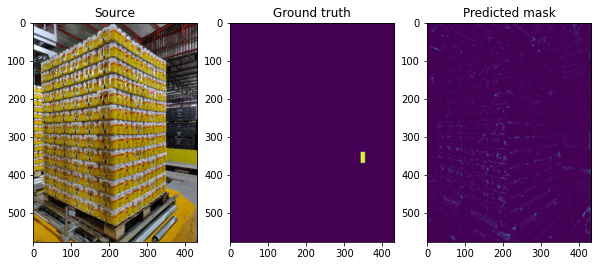

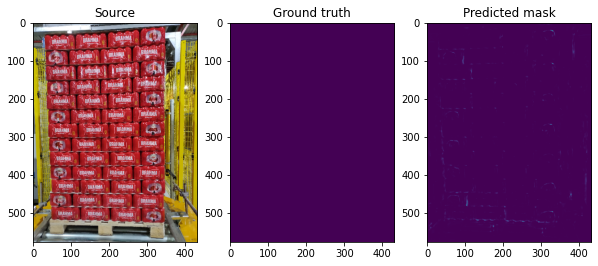

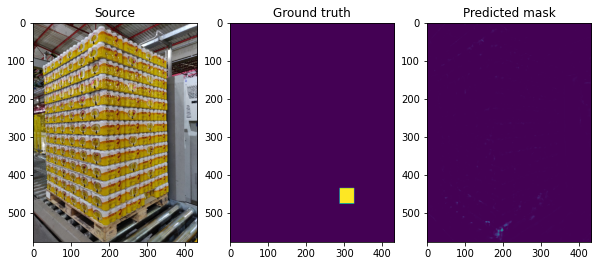

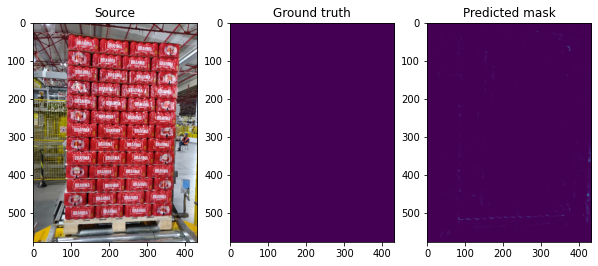

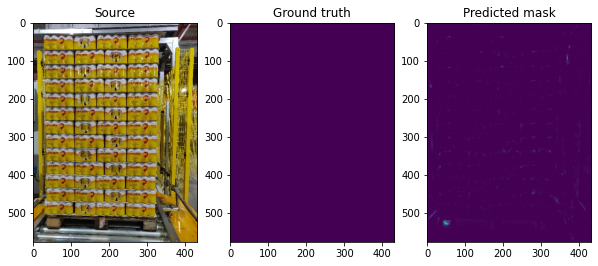

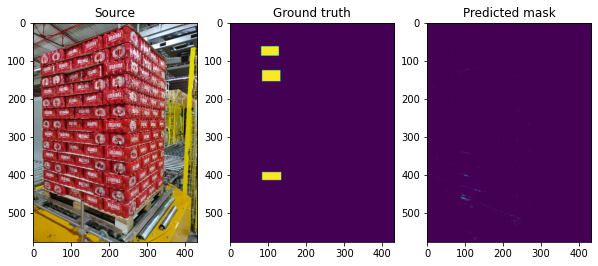

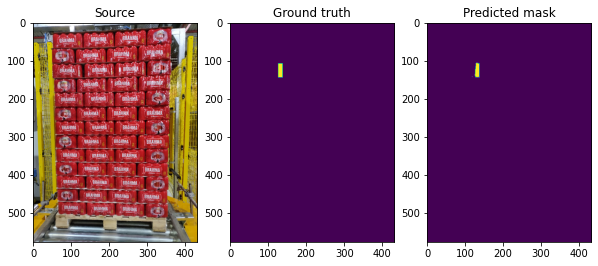

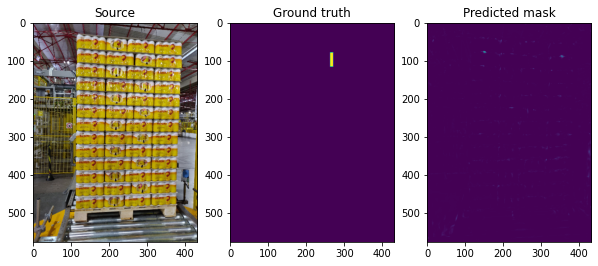

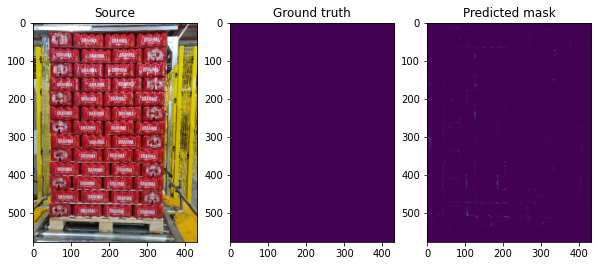

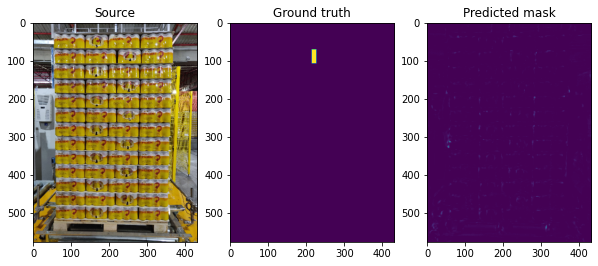

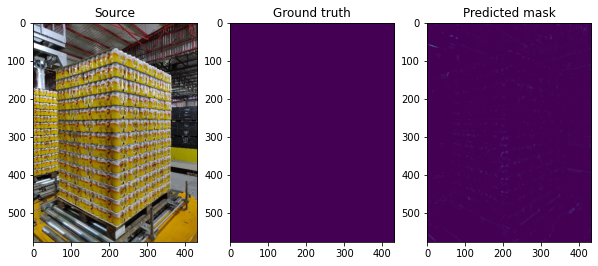

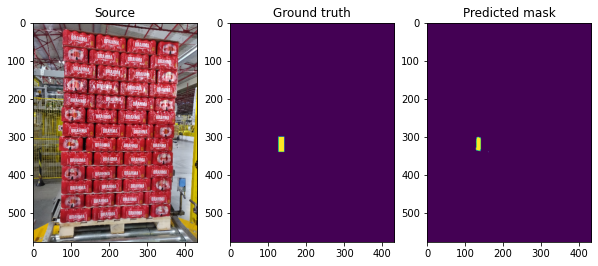

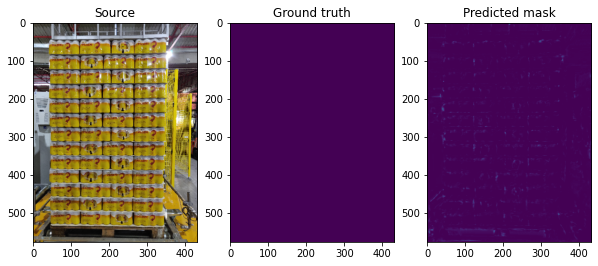

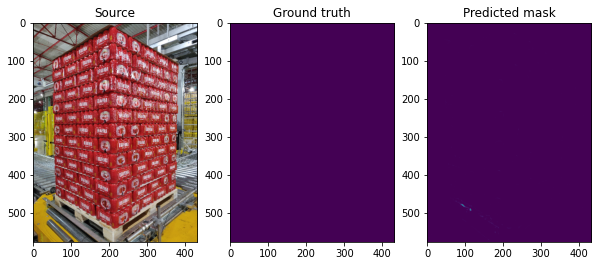

Test IoU : 0.10800638589172097
Accuracy : 0.6428571428571429
Precision: 1.0
Recall   : 0.2857142857142857


In [ ]:
eval_model(net, test_loader, device)

# Conclusions

Simple research model was implemented, based on segmentation model UNet [https://arxiv.org/abs/1505.04597](Unet). This approach usually requires less data than other segmentation models and shows good performance on similar tasks.

The model was trained with limited  dataset (140 samples), without formal definition what is to be considered as defects. The images provided are not conforming to technical requirements (angles, aperture, quantity).

Recommendations for further development:

**Dataset Preparation**
* Images should be taken by DSLR camera, in color, with normal lighting on the production floor.
* The shots should not be blurry.
* The flashlight should be turned off.
* Images should be saved as color JPEG images with the quality setting 90%, pixel dimensions about 2592x2048.
Every single pallet can be photographed 10-15 times varying:
* Camera height: above the top of the pallet, in the middle, closer to the floor (3-4 positions);
Camera angle (3-4 positions);
* In every shot, the pallet should be completely visible and occupy at least 75% of the shot area, having a pallet in the image center.
* There should not be a fence nor other obstacles (people, equipment, etc.) between the camera and the pallet.
* If the pallet has a defect to be identified by the software, the defect should be clearly visible on the photo. 
* For plastic-wrapped pallet please take photos of several varieties of products (can labels, sizes).

**Photo labeling**
* The photos should be sorted by folders (good pallets, misaligned cases layers etc)
* If a photo contains two or more types of problems, place a copy of the photo to each folder.
* 30% of captured images should be retained for testing purposes. This testing set should be withdrawn randomly from each of the 6 folders mentioned above.

**Quantity of images:**
* total number of photos: 2,500.
* total number of additional testing photos: 800.
